# Práctica 8: Residual neural networks - Parte 2


### Pre-requisitos. Instalar paquetes

Para la segunda parte de este Laboratorio 8 necesitaremos TensorFlow y TensorFlow-Datasets. Además, como habitualmente, fijaremos la semilla aleatoria para asegurar la reproducibilidad de los experimentos.

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Fijamos la semilla para poder reproducir los resultados
import os
import numpy as np
import random
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

Además, cargamos también APIs que vamos a emplear para que el código quede más legible

In [27]:
#API de Keras, modelo Sequential y la capa Dense 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense 
#Para mostrar gráficas
from matplotlib import pyplot

### Carga del conjunto de datos

De nuevo, seguimos empleando el conjunto *german_credit_numeric* ya empleado en los laboratorios anteriores.

In [28]:
# TODO: Carga el conjunto german_credit como ds_train
# Indica además un tamaño de batch de 128 y que se repita indefinidamente
ds_train = tfds.load('german_credit_numeric', split='train',as_supervised=True).batch(128).repeat()

## Visualización del desvanecimiento del gradiente
En este apartado visualizaremos los tamaños de los gradientes, como hicimos en la primera parte. Para ello mantenemos la declaración de `GradientLoggingSequentialModel`.

In [29]:
class GradientLoggingSequentialModel(tf.keras.models.Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # En la inicialización instanciamos una nueva variable en la que
        # registraremos el historial de tamaños de gradientes de cada capa
        self.gradient_history = {}
    
    def compile(self, **kwargs):
        result = super().compile(**kwargs)
        # Una vez sabemos la arquitectura, podemos inicializar la historia
        # de gradientes de cada capa a una lista vacía.
        for l in self.layers:
            self.gradient_history[l.name] = []
        return result
        
    def _save_gradients(self, gradients):
        # A cada paso de entrenamiento llamaremos a esta función para que
        # registre los gradientes.
        # En la lista gradients se encuentran los gradientes de las distintas
        # capas por orden. Cada capa l tendrá un número de gradientes que
        # concidirá con l.trainable_variables.
        # Teniendo esto en cuenta, recorremos los gradientes, calculamos su
        # tamaño y guardamos la media de tamaños de cada capa en el histórico
        i = 0
        for layer in self.layers:
            gradient_sizes = []
            for lw in layer.trainable_variables:
                g_size = np.linalg.norm(gradients[i].numpy())
                gradient_sizes.append(g_size)
                i += 1
            mean_gradient_size = np.mean(gradient_sizes)
            self.gradient_history[layer.name].append(mean_gradient_size)
        
    def train_step(self, data):
        # Haremos un paso de entrenamiento personalizado basado en 
        # https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#a_first_simple_example
        # Dejaremos el ejemplo tal cual, añadiendo tan solo la llamada a
        # _save_gradients una vez que disponemos de los gradientes
        
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        
        # Llamada añadida para grabar los gradientes.
        self._save_gradients(gradients)
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

### Creación del bloque con conexión residual

En una red neuronal *feed-forward* convencional, la salida de cada capa se utiliza como entrada de las capa siguiente.
<img src="./img/resnet.png" alt="Dos capas en una red FF" width="400"/>

En contraste, en una ResNet se introducen bloques que incluyen conexiones residuales con el objetivo de favorecer la propagación de los gradientes.
<img src="./img/resnet-2.png" alt="Dos capas en una red FF con conexión residual" width="400"/>

A pesar de que las ResNet se suelen utilizar con redes convolucionales, en este Laboratorio utilizaremos una red *feed-forward*.

Para poder utilizar este tipo de bloques en nuestra arquitectura definiremos un nuevo tipo de modelo denominado `DoubleDenseWithSkipModel` que consistirá en lo representado en la imagen:
 - Una primera capa Dense, cuya salida sirve de entrada a...
 - Una segunda capa Dense lineal (sin activación), cuya salida sirve de entrada a...
 - A una operación suma que la añade a la entrada original a la primera capa. La salida de esta suma servirá de entrada a...
 - Una función de activación, cuya salida será la salida del bloque.

Utilizaremos la función sigmoide como función de activación en ambos casos. La entrada y la salida del bloque deberán tener la misma dimensión para que se pueda realizar la suma. Por simplicidad, mantendremos la salida de la primera capa con la misma dimensión.

Nuestra nueva clase heredará de `Model`, por lo que deberá implementar los métodos `build` y `call`. En celdas posteriores añadiremos estos bloques a un modelo `Sequential` como si fuesen capas.

In [30]:
class DoubleDenseWithSkipModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super(DoubleDenseWithSkipModel, self).__init__(**kwargs)

    # TODO: Completa el método build
    def build(self, input_shape):
        # Cojemos el numero de caracteristicas con input_shape[-1]
        self.dense1 = tf.keras.layers.Dense(input_shape[-1], activation="sigmoid")
        self.dense2 = tf.keras.layers.Dense(input_shape[-1])

        
    # TODO: Completa el método skip
    def call(self, x):
        # Primera capa dense
        h0 = self.dense1(x)
        # Segunda capa dense sin activacion
        h1 = self.dense2(h0)    
        # Suma de la salida con la entrada original
        h2 = h1 + x
        # Activacion de la salida
        return tf.keras.activations.sigmoid(h2)

## Creamos un modelo *GradientLoggingSequentialModel* utilizando las nuevas capas
Creamos un modelo *GradientLoggingSequentialModel* para ajustar a los datos de entrada siguiendo las especificaciones dadas. Deberá incluir (además de las capas de entrada y salida) una capa de 10 unidades con activación sigmoide y 10 de los nuevos bloques.

In [31]:
# TODO - Define en model una red GradientLoggingSequentialModel
# Pon una capa densa con 10 unidades con activación sigmoide y 10 capas DoubleDenseWithSkipModel

layers = [tf.keras.layers.InputLayer(input_shape=(24,))]  # Especifica la forma de entrada
layers.append(tf.keras.layers.Dense(10, activation="sigmoid"))
layers += [DoubleDenseWithSkipModel() for _ in range(10)]
layers.append(tf.keras.layers.Dense(1, activation="softmax"))  # capa de salida

model = GradientLoggingSequentialModel(layers=layers)

#Construimos el modelo y mostramos 
model.build()
print(model.summary())

Model: "gradient_logging_sequential_model_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_70 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_71 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_72 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_73 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_74 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_75 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_76 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_77 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_78 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_79 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,461 (9.61 KB)

 Trainable params: 2,461 (9.61 KB)

 Non-trainable params: 0 (0.00 B)

None


### Entrenamiento del modelo
Como en la primera parte, vamos a establecer la función de pérdida (entropía cruzada binaria), el optimizador (SGD con LR $10^{-3}$) y la métrica que nos servirá para evaluar el rendimiento del modelo entrenado (área bajo la curva).

In [32]:
#TODO - Compila el modelo. Utiliza la opción run_eagerly=True para que se puedan registrar los gradientes a cada paso

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              run_eagerly=True)


Entrenamos el modelo usando model.fit

In [33]:
#TODO - entrenar el modelo utilizando 8 steps por epoch. Con 10 epochs nos valdrá para comprobar el desvanecimiento de gradientes.

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(ds_train, epochs=num_epochs, steps_per_epoch=8)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.0000


Una vez hayas encontrado un valor de learning rate que consiga una convergencia rápida, guarda el history de la pérdida en la variable history_sgd para poder hacer comparativas.

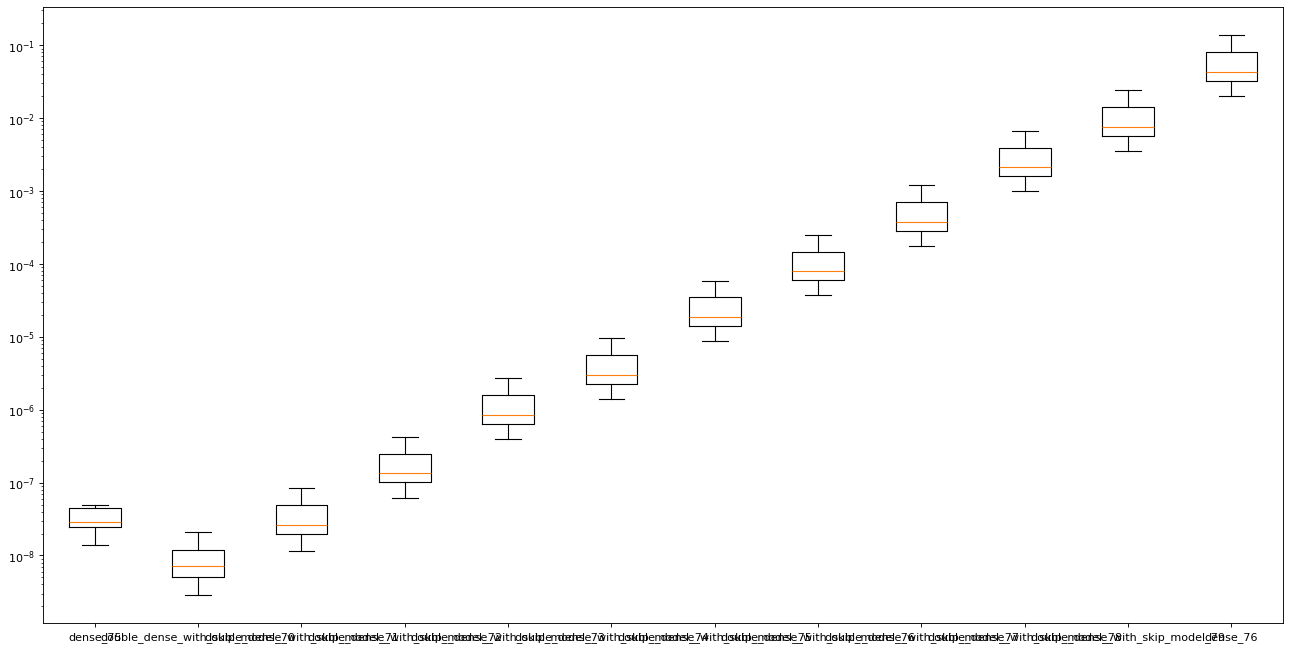

In [35]:
pyplot.figure(figsize=(20, 10), dpi=80)
pyplot.boxplot(model.gradient_history.values())
pyplot.yscale('log')
pyplot.xticks(ticks=range(1,len(model.gradient_history)+1), labels=model.gradient_history.keys())
pyplot.show()

# USO DE RELU

In [36]:
class DoubleDenseWithSkipModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super(DoubleDenseWithSkipModel, self).__init__(**kwargs)

    # TODO: Completa el método build
    def build(self, input_shape):
        # Cojemos el numero de caracteristicas con input_shape[-1]
        self.dense1 = tf.keras.layers.Dense(input_shape[-1], activation="relu")
        self.dense2 = tf.keras.layers.Dense(input_shape[-1])

        
    # TODO: Completa el método skip
    def call(self, x):
        # Primera capa dense
        h0 = self.dense1(x)
        # Segunda capa dense sin activacion
        h1 = self.dense2(h0)    
        # Suma de la salida con la entrada original
        h2 = h1 + x
        # Activacion de la salida
        return tf.keras.activations.sigmoid(h2)

In [37]:
# TODO - Define en model una red GradientLoggingSequentialModel
# Pon una capa densa con 10 unidades con activación sigmoide y 10 capas DoubleDenseWithSkipModel

layers = [tf.keras.layers.InputLayer(input_shape=(24,))]  # Especifica la forma de entrada
layers.append(tf.keras.layers.Dense(10, activation="relu"))
layers += [DoubleDenseWithSkipModel() for _ in range(10)]
layers.append(tf.keras.layers.Dense(1, activation="softmax"))  # capa de salida

model = GradientLoggingSequentialModel(layers=layers)

#Construimos el modelo y mostramos 
model.build()
print(model.summary())

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "gradient_logging_sequential_model_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_97 (Dense)                │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_80 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_81 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_82 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_83 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_84 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_85 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_86 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_87 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_88 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_89 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,461 (9.61 KB)

 Trainable params: 2,461 (9.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
#TODO - Compila el modelo. Utiliza la opción run_eagerly=True para que se puedan registrar los gradientes a cada paso

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              run_eagerly=True)


In [39]:
#TODO - entrenar el modelo utilizando 8 steps por epoch. Con 10 epochs nos valdrá para comprobar el desvanecimiento de gradientes.

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(ds_train, epochs=num_epochs, steps_per_epoch=8)

Epoch 1/10
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:615: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:590: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0000
Epoch 2/10
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0000
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0000


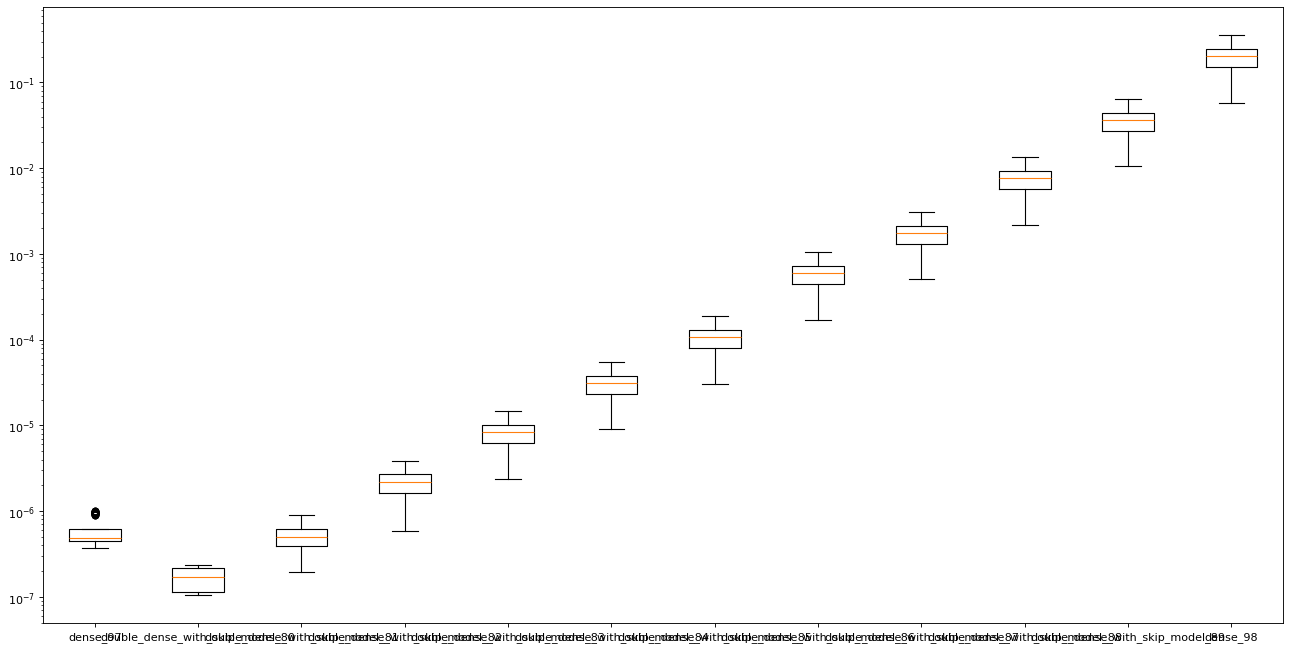

In [40]:
pyplot.figure(figsize=(20, 10), dpi=80)
pyplot.boxplot(model.gradient_history.values())
pyplot.yscale('log')
pyplot.xticks(ticks=range(1,len(model.gradient_history)+1), labels=model.gradient_history.keys())
pyplot.show()

In [41]:
# TODO - Define en model una red GradientLoggingSequentialModel
# Pon una capa densa con 10 unidades con activación sigmoide y 10 capas DoubleDenseWithSkipModel

layers = [tf.keras.layers.InputLayer(input_shape=(24,))]  # Especifica la forma de entrada
layers.append(tf.keras.layers.Dense(10, activation="leaky_relu"))
layers += [DoubleDenseWithSkipModel() for _ in range(10)]
layers.append(tf.keras.layers.Dense(1, activation="softmax"))  # capa de salida

model = GradientLoggingSequentialModel(layers=layers)

#Construimos el modelo y mostramos 
model.build()
print(model.summary())

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "gradient_logging_sequential_model_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_119 (Dense)               │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_90 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_91 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_92 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_93 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_94 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_95 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_96 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_97 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_98 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ double_dense_with_skip_model_99 │ (None, 10)             │           220 │
│ (DoubleDenseWithSkipModel)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,461 (9.61 KB)

 Trainable params: 2,461 (9.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
#TODO - Compila el modelo. Utiliza la opción run_eagerly=True para que se puedan registrar los gradientes a cada paso

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              run_eagerly=True)


In [43]:
#TODO - entrenar el modelo utilizando 8 steps por epoch. Con 10 epochs nos valdrá para comprobar el desvanecimiento de gradientes.

num_epochs = 20

# Entrenamiento del modelo
history = model.fit(ds_train, epochs=num_epochs, steps_per_epoch=8)

Epoch 1/20


/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:615: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:590: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 2/20


/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 1.0000
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 1.0000
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 1.0000
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 1.0000
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 1.0000
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 1.0000
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 1.0000
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.0000
Epoch 17/20
8/8 ━━━━━━━━━━━━━

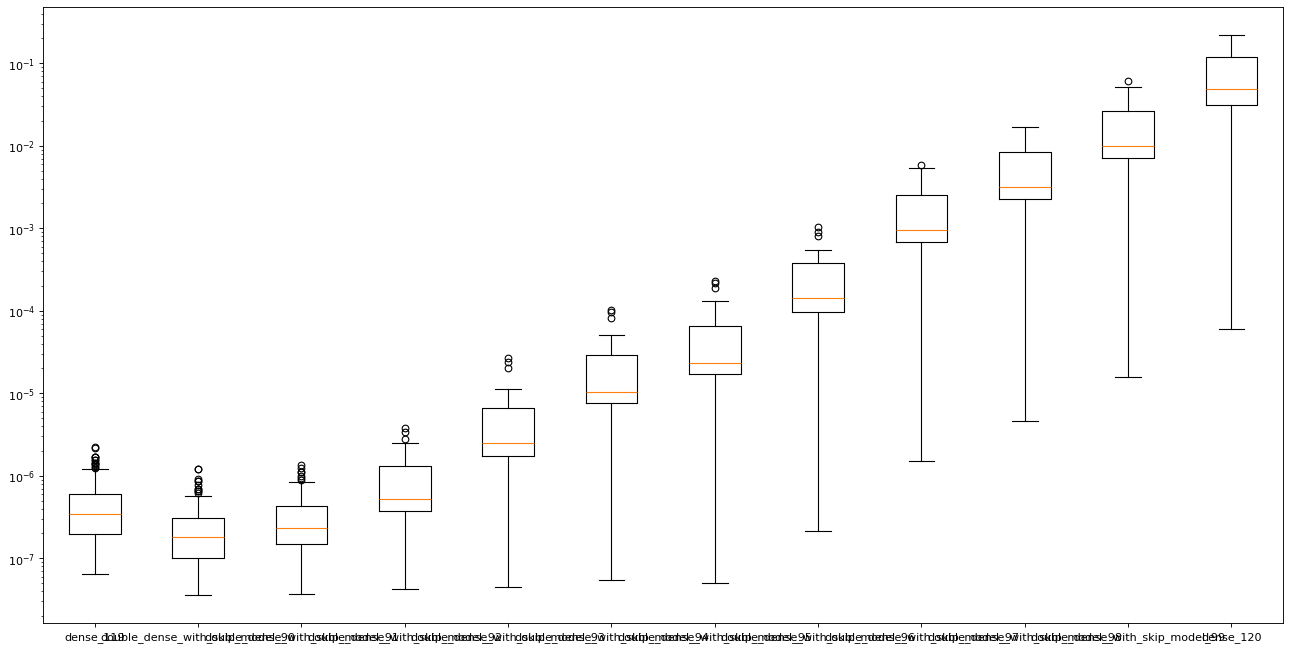

In [44]:
pyplot.figure(figsize=(20, 10), dpi=80)
pyplot.boxplot(model.gradient_history.values())
pyplot.yscale('log')
pyplot.xticks(ticks=range(1,len(model.gradient_history)+1), labels=model.gradient_history.keys())
pyplot.show()

## Comparativa
 - Contrasta los resultados con los obtenidos en la primera parte

La incializacióin de los pesos es mejor, al obtener unos gradientes mas altos al comienzo. Por ello podemos deducir una mejora gracias al uso de las capas residuales.

 - Cambia las activaciones del bloque y de la primera capa oculta de la red a ReLU y observa la diferencia.


 - Alarga el entrenamiento y prueba distintos optimizadores para intentar que el modelo entrene correcto

 